In [1]:
######################################################################
# DEPENDENCES
######################################################################

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# # Modelling Algorithms
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier

# # Modelling Helpers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import explained_variance_score
# from sklearn.preprocessing import Imputer
# from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import scale
# from sklearn.cross_validation import train_test_split
# from sklearn.cross_validation import StratifiedKFold
# from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
# import graphviz

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

# Numeric attributes
numeric_attributes = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond',
                      'YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF2','BsmtUnfSF',
                      'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                      'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
                      'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars',
                      'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
                      'ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']

In [2]:
######################################################################
# HELPER FUNCTIONS
######################################################################

def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure() # figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_pairwise_relationships(df, x_vars, y_vars):
    sns.pairplot(data, y_vars=y_vars,x_vars=x_vars)
    
def plot_triple_relationships(df, x, y, groupby, bars=True):
    if bars:
        sns.barplot(x=x, y=y, hue=groupby, data=df)
    else:
        sns.pointplot(x=x, y=y, hue=groupby, data=df);
    
def plot_distribution( df , target , var , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=var , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , target , shade= True )
    facet.set( xlim=( 0 , df[ target ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_regression(df,x_var,y_var):
    sns.jointplot(x=x_var, y=y_var, data=df, kind="reg");
    #sns.lmplot(x=x_var, y=y_var, data=df, hue=groupby);
    
def plot_residuals(df,x_var,y_var):
    sns.residplot(x=x_var, y=y_var, data=df, scatter_kws={"s": 80});
    
def plot_prediction(X_test, y_test, y_prediction, y_variable, x_groupby_y):
    df_test = pd.concat([X_test, y_test],axis=1)
    df_prediction = pd.DataFrame(data=y_prediction,index=y_test.index,columns=[y_variable])
    df_prediction = pd.concat([X_test, df_prediction],axis=1)
    data_all = pd.concat(dict(data=df_test[x_groupby_y], model=df_prediction[x_groupby_y]),names=["kind"]).reset_index()
    sns.factorplot(x_groupby_y[0], x_groupby_y[2], "kind", data=data_all, col=x_groupby_y[1],kind="point", linestyles=["-", "--"], markers=["o", "D"])

def plot_correlation_map( df , annot=True):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = annot, 
        annot_kws = { 'fontsize' : 12 }
    )

def plot_correlation_cluster(df):
    corr = df.corr()
    sns.clustermap(data.corr())
    
def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y, model ):
    plot_model_var_imp( X , y, model )
    
def plot_model_var_imp( X , y, model ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ('\n- Model score: {}'.format(model.score( X , y )))
    
def plot_cross_validated_predictions_linear_regression(X,y):
    lr = LinearRegression()
    # cross_val_predict returns an array of the same size as `y` where each entry
    # is a prediction obtained by cross validation:
    predicted = cross_val_predict(lr, X, y, cv=10)
    fig, ax = plt.subplots()
    ax.scatter(y, predicted, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    plt.close()

def plot_predicted_vs_expected(X_test,y_test,y_pred):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Expected')
    ax.set_ylabel('Predicted')
    plt.show()
    plt.close()

def plot_decision_tree(model, max_depth, feature_names, fn):
    dot_data = tree.export_graphviz(model, out_file=None, max_depth=max_depth,
                         feature_names=feature_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = graphviz.Source(dot_data)  
    graph.render(fn) 
    print('decision tree (showin top {} level) plot: {}.pdf'.format(max_depth, fn))

def get_mae(max_leaf_nodes, predictors_train, predictors_val, targ_train, targ_val):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(predictors_train, targ_train)
    preds_val = model.predict(predictors_val)
    mae = mean_absolute_error(targ_val, preds_val)
    return(mae)

def evaluation_regression(y_test, y_pred):
    print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_pred)))
    print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_pred)))
    print('Median Absolute Error: {}'.format(median_absolute_error(y_test, y_pred)))
    print('Explained Variance: {}'.format(explained_variance_score(y_test, y_pred)))

def filter_numeric_predictors(data_1, y_variable, data_2=None):
    data_1.dropna(axis=1,how='any',inplace=True)
    if data_2 is not None:
        data_2.dropna(axis=1,how='any',inplace=True)
        attributes = set(data_train.columns).intersection(set(data_test.columns))
        attributes.discard(y_variable)
    else:
        attributes = data.columns
        attributes.drop(y_variable)
    predictors = numeric_attributes.copy()
    print('{} predictors'.format(len(predictors)))
    to_delete = [p for p in predictors if p not in attributes]
    for p in to_delete:
        predictors.remove(p)
    print('{} valid predictors'.format(len(predictors)))
    return data_1,predictors,data_2

# LOADING DATA

In [3]:
######################################################################

main_file_path = 'data/train.csv'
data = pd.read_csv(main_file_path)
print('hello world!')

hello world!


In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
data.describe()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
describe_more(data)


,Variable,Levels,Datatype
41,CentralAir,2,object
9,Utilities,2,object
5,Street,2,object
6,Alley,2,object
48,BsmtHalfBath,3,int64
11,LandSlope,3,object
60,GarageFinish,3,object
50,HalfBath,3,int64
65,PavedDrive,3,object
72,PoolQC,3,object


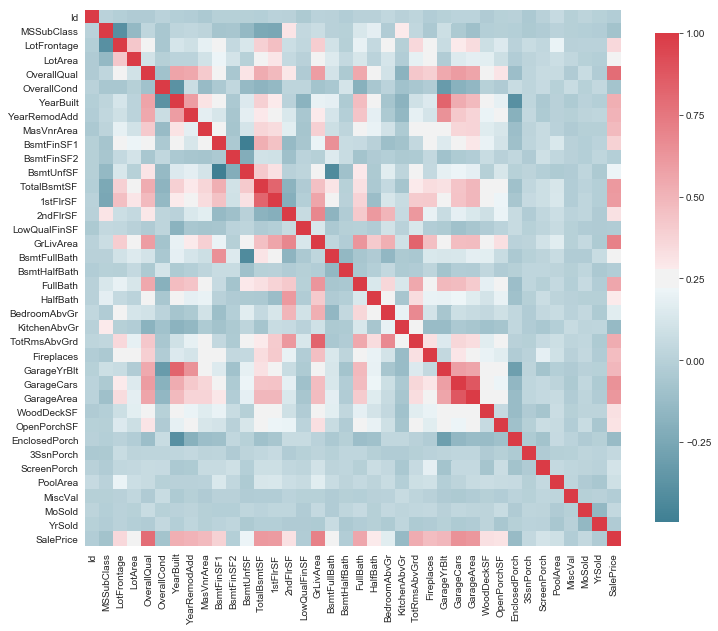

In [8]:
plot_correlation_map( data , False )

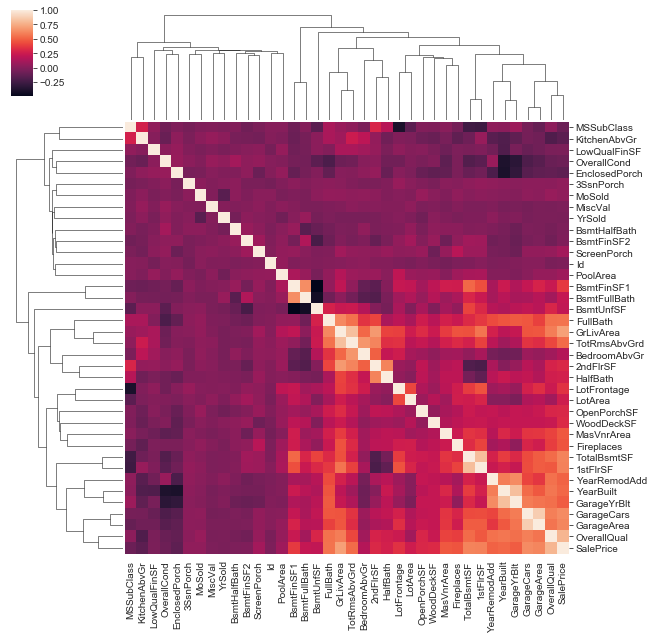

In [9]:
plot_correlation_cluster(data)

C:\Users\Latitude E7450\Anaconda3\envs\ml_tutorial\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Latitude E7450\Anaconda3\envs\ml_tutorial\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Latitude E7450\Anaconda3\envs\ml_tutorial\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Latitude E7450\Anaconda3\envs\ml_tutorial\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Latitude E7450\Anaconda3\envs\ml_tutorial\lib\site-packages\seaborn\axisgrid.py:715: Us

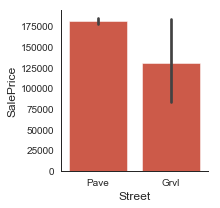

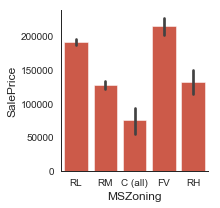

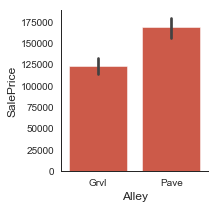

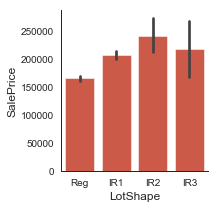

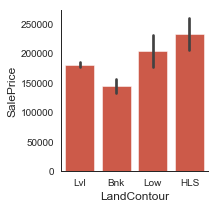

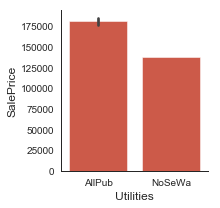

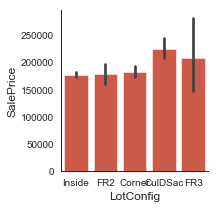

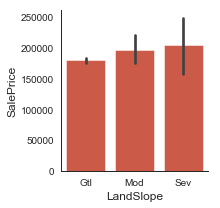

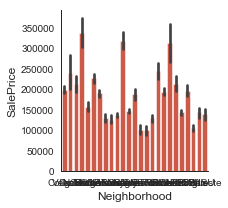

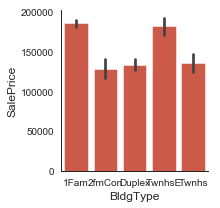

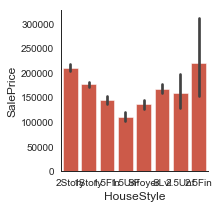

In [10]:
categories = ['Street','MSZoning','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','BldgType','HouseStyle']
for cat in categories:
    plot_categories( data , cat = cat , target = 'SalePrice' )

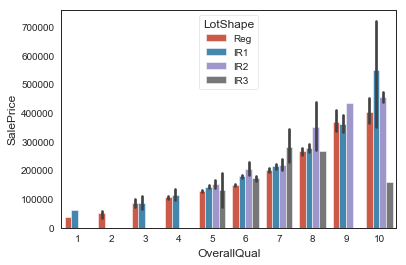

In [11]:
plot_triple_relationships(data, x="OverallQual", y="SalePrice", groupby="LotShape", bars=True)

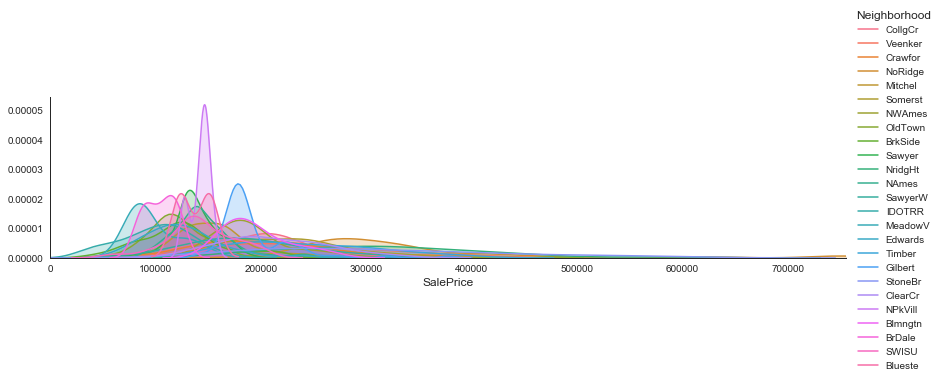

In [12]:
plot_distribution( data  , 'SalePrice', 'Neighborhood')

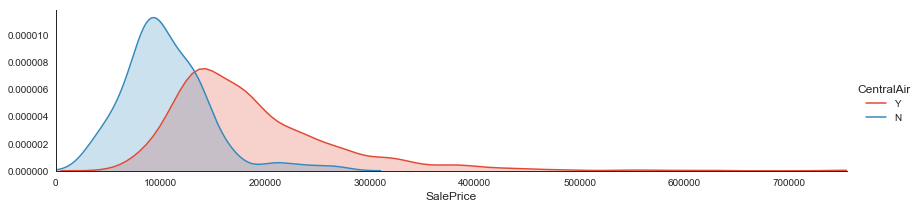

In [13]:
plot_distribution( data  , 'SalePrice', 'CentralAir')

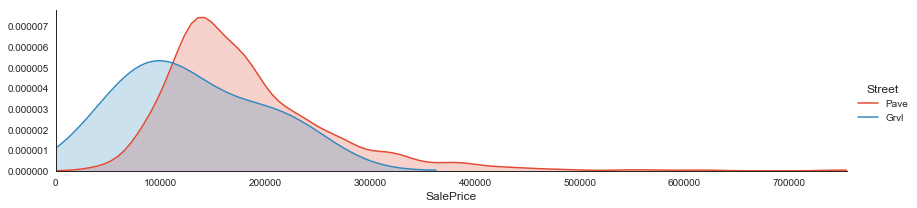

In [14]:
plot_distribution( data  , 'SalePrice', 'Street')

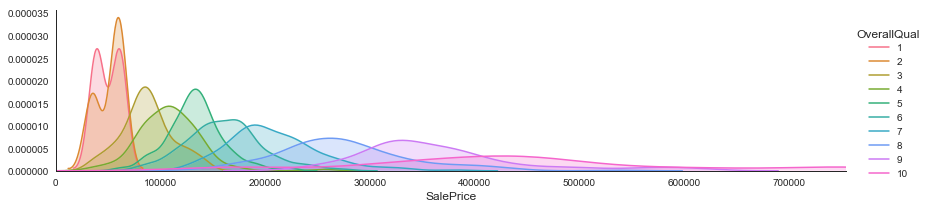

In [15]:
plot_distribution( data  , 'SalePrice', 'OverallQual')

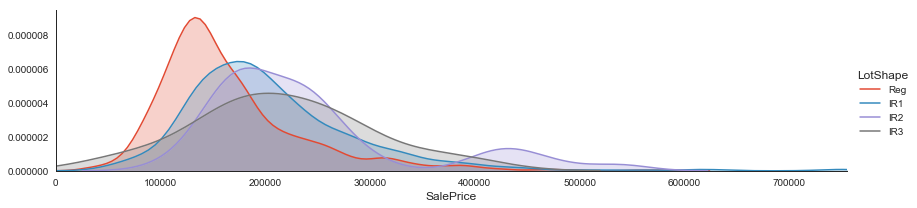

In [16]:
plot_distribution( data  , 'SalePrice', 'LotShape')

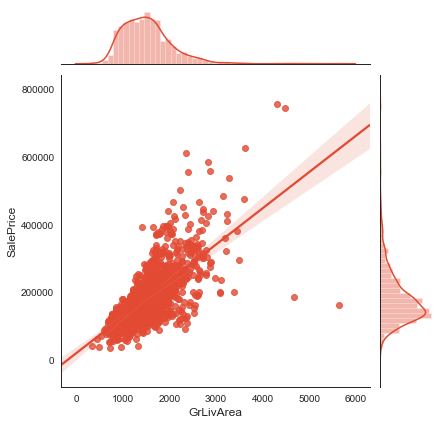

In [17]:
plot_regression(data,x_var='GrLivArea',y_var='SalePrice')

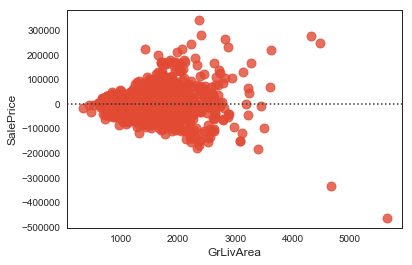

In [18]:
plot_residuals(data,x_var='GrLivArea',y_var='SalePrice')

# Decission Trees Regressor

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Predictors: ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']

Making predictions for the following 5 houses:
   LotArea  YearBuilt  1stFlrSF  2ndFlrSF  FullBath  BedroomAbvGr  \
0     8450       2003       856       854         2             3   
1     9600       1976      1262         0         2             3   
2    11250       2001       920       866         2             3   
3     9550       1915       961       756         1             3   
4    14260       2000      1145      1053         2             4   

   TotRmsAbvGrd  
0             8  
1             6  
2             6  
3             7  
4             9  
The predic

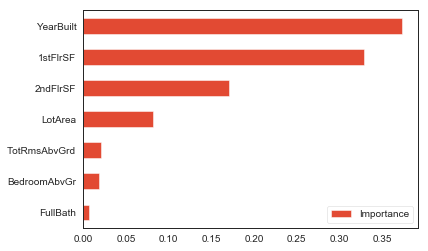

In [19]:
predictors = ['LotArea','YearBuilt','1stFlrSF','2ndFlrSF','FullBath','BedroomAbvGr','TotRmsAbvGrd']
X = data[predictors]
y = data.SalePrice

# Model
model = DecisionTreeRegressor()
print(model)
model.fit(X, y)

# Prediction on a sample
print('\nPredictors: {}'.format(predictors))
print("\nMaking predictions for the following 5 houses:")
print(X.head())
print("The predictions are")
print(model.predict(X.head()))

# Plotting variable importance
plot_variable_importance(X,y,model)

# Evaluacija

=== Making predictions on train data ===
Mean Absolute Error: 62.35433789954339
Mean Squared Error: 412288.4155251142
Median Absolute Error: 0.0
Explained Variance: 0.9999346278363472
=== Making predictions on test data ===
Mean Absolute Error: 31363.224657534247
Mean Squared Error: 2488082210.660274
Median Absolute Error: 18000.0
Explained Variance: 0.62351213759047

- Model score: 0.9999173683841396


NameError: name 'graphviz' is not defined

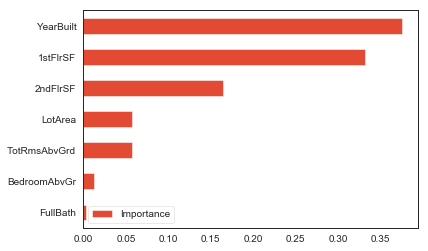

In [20]:
predicted_prices = model.predict(X)
print('=== Making predictions on train data ===')
evaluation_regression(y, predicted_prices)

# Validation on test data
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0)
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
test_predictions = model.predict(X_test)
print('=== Making predictions on test data ===')
evaluation_regression(y_test, test_predictions)

# variable importance
plot_variable_importance(X_train, y_train, model)

# plotting deceision tree (only most important decisions (top 5 levels))
plot_decision_tree(model, max_depth=5, feature_names=predictors, fn="decision_tree")

In [21]:
for max_leaf_nodes in [2, 5, 10, 20, 25, 30, 45, 50, 55, 60, 100, 500, 1000, 5000]:
    mae = get_mae(max_leaf_nodes, X_train, X_test, y_train, y_test)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, mae))

Max leaf nodes: 2  		 Mean Absolute Error:  45933
Max leaf nodes: 5  		 Mean Absolute Error:  35190
Max leaf nodes: 10  		 Mean Absolute Error:  30616
Max leaf nodes: 20  		 Mean Absolute Error:  29206
Max leaf nodes: 25  		 Mean Absolute Error:  28501
Max leaf nodes: 30  		 Mean Absolute Error:  28302
Max leaf nodes: 45  		 Mean Absolute Error:  27531
Max leaf nodes: 50  		 Mean Absolute Error:  27825
Max leaf nodes: 55  		 Mean Absolute Error:  27881
Max leaf nodes: 60  		 Mean Absolute Error:  28072
Max leaf nodes: 100  		 Mean Absolute Error:  28653
Max leaf nodes: 500  		 Mean Absolute Error:  32662
Max leaf nodes: 1000  		 Mean Absolute Error:  33385
Max leaf nodes: 5000  		 Mean Absolute Error:  33382


# Random Forest

In [22]:
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)
forest_prediction = forest_model.predict(X_test)
evaluation_regression(y_test, forest_prediction)


Mean Absolute Error: 23775.804429223746
Mean Squared Error: 1393315380.9653006
Median Absolute Error: 15130.0
Explained Variance: 0.7894029038732258


35 predictors
32 valid predictors
Mean Absolute Error: 18304.645205479454
Mean Squared Error: 930700878.770548
Median Absolute Error: 11810.0
Explained Variance: 0.859333930809032

- Model score: 0.9690701916758792


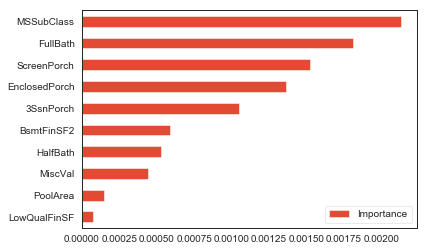

In [23]:
data = pd.read_csv('data/train.csv')
y_variable = 'SalePrice'
data, predictors, _ = filter_numeric_predictors(data, y_variable)

X = data[predictors]
y = data.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0)

forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)
forest_prediction = forest_model.predict(X_test)
evaluation_regression(y_test, forest_prediction)

# Plotting variable importance
plot_variable_importance(X_train, y_train, forest_model)

In [24]:
', '.join(predictors)


'MSSubClass, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold'

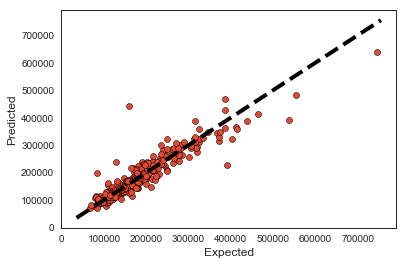

In [25]:
plot_predicted_vs_expected(X_test, y_test, forest_prediction)
